# Torch
## Check GPU¶

In [1]:
import torch
import sys
sys.path.append('..')
from torchlib.utils import list_device,set_device

list_device()

the rosdep view is empty: call 'sudo rosdep init' and 'rosdep update'


------------ List Devices ------------
Device 0 :
GeForce RTX 2060
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB

Device 1 :
TITAN Xp
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB



## Set torch default parameters¶

In [2]:
set_device(1)
import numpy as np
np.set_printoptions(precision = 2)
torch.set_default_dtype(torch.float32)
torch.set_printoptions(precision=4)
torch.backends.cudnn.benchmark = True
torch.set_printoptions(sci_mode=False)

Using Device 1 : TITAN Xp


# Set Arguments

In [3]:
import argparse
import sys
import os
import time
import pickle

parser = argparse.ArgumentParser()

'''Training Parameters'''
parser.add_argument('--batch_size', type=int, default=300, help='minibatch size')
parser.add_argument('--num_epochs', type=int, default=200, help='number of epochs')
parser.add_argument('--grad_clip', type=float, default=5., help='clip gradients at this value')
parser.add_argument('--learning_rate', type=float, default=0.05, help='learning rate')
parser.add_argument('--learning_rate_clip', type=float, default=0.0000001, help='learning rate clip')
parser.add_argument('--decay_rate', type=float, default=.7, help='decay rate for rmsprop')
parser.add_argument('--weight_decay', type=float, default=.0001, help='decay rate for rmsprop')
parser.add_argument('--batch_norm_decay', type=float, default=.999, help='decay rate for rmsprop')
parser.add_argument('--keep_prob', type=float, default=1.0, help='dropout keep probability')
parser.add_argument('--lamda_weights', type=float, default=.01, help='lamda weight')
parser.add_argument('--data_argumentation', type=bool, default=True, help='whether do data argument')
parser.add_argument('--is_normalization', type=bool, default=True, help='whether do data nomalization')
parser.add_argument('--target_image_size', default=[300, 300], nargs=2, type=int, help='Input images will be resized to this for data argumentation.')
parser.add_argument('--output_dim', default=3, type=int, help='output dimention.')
parser.add_argument('--feat_dim', default=128, type=int, help='feature dimention.')

'''Configure'''
parser.add_argument('--network', type=str, default='vggnet_localization')
parser.add_argument('--model_dir', type=str, default='/notebooks/global_localization/gps_grid_torch', help='rnn, gru, or lstm')

parser.add_argument('--train_dataset', type=str, default = ['/notebooks/michigan_nn_data/2012_01_08',
                                                            '/notebooks/michigan_nn_data/2012_01_15',
                                                            '/notebooks/michigan_nn_data/2012_01_22',
                                                            '/notebooks/michigan_nn_data/2012_02_02',
                                                            '/notebooks/michigan_nn_data/2012_02_04',
                                                            '/notebooks/michigan_nn_data/2012_02_05',
                                                            '/notebooks/michigan_nn_data/2012_03_31',
                                                            '/notebooks/michigan_nn_data/2012_09_28'])
'''
#parser.add_argument('--train_dataset', type=str, default = ['/notebooks/michigan_nn_data/test'])
parser.add_argument('--train_dataset', type=str, default = ['/notebooks/michigan_nn_data/2012_01_08'])
'''
parser.add_argument('--norm_tensor', type=str, default = ['/notebooks/global_localization/norm_mean_std.pt'])

parser.add_argument('--seed', default=1337, type=int)
parser.add_argument('--save_every', type=int, default=500, help='save frequency')
parser.add_argument('--display', type=int, default=10, help='display frequency')
parser.add_argument('--tensorboard', type=bool, default=True, help='open tensorboard')

sys.argv = ['']
args = parser.parse_args()

if args.tensorboard:
    import os
    os.system('rm -rf runs/gps_grid')
    from torch.utils.tensorboard import SummaryWriter
    writer = SummaryWriter('runs/gps_grid')

# Load Dataset

In [4]:
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import tf.transformations as tf_tran
from tqdm import tqdm
from PIL import Image
import numpy as np
import random

#import gpflow.multioutput.kernels as mk
import gpytorch

import torch.nn as nn
import torch.optim as optim
from torchlib import resnet, vggnet
from torchlib.cnn_auxiliary import normalize, denormalize_navie, denormalize, get_relative_pose, translational_rotational_loss
from torchlib.utils import LocalizationDataset, display_loss, data2tensorboard
import time

transform = transforms.Compose([transforms.ToTensor()])
dataset = LocalizationDataset(dataset_dirs = args.train_dataset, \
                              image_size = args.target_image_size, \
                              transform = transform, get_pair = False)

if len(args.train_dataset)>7:
    [args.norm_mean, args.norm_std] = [torch.tensor(x) for x in dataset.get_norm()]
    torch.save([args.norm_mean, args.norm_std], *args.norm_tensor)
    print('Save norm and std:',*args.norm_tensor)
else:
    [args.norm_mean, args.norm_std] = torch.load(*args.norm_tensor)
    print('Load norm and std:',*args.norm_tensor)


dataloader = DataLoader(dataset, batch_size=args.batch_size, \
                        shuffle=True, num_workers=0, \
                        drop_last=True, pin_memory=True)

100%|██████████| 14037/14037 [00:34<00:00, 412.51it/s]


Save norm and std: /notebooks/global_localization/norm_mean_std.pt


# Grid

In [13]:
import math
import pickle

class Grid:
    def __init__(self,grid_size=100.,overlap=50.,**kwargs):
        self.grid_size = grid_size
        self.overlap = overlap
        if 'data' in kwargs:
            data = kwargs['data']
            assert data.shape[1] == 2
            self.boundary_x = [np.min(data[:,0]), np.max(data[:,0])]
            self.boundary_y = [np.min(data[:,1]), np.max(data[:,1])]
            self.num_grid_x,self.num_grid_y = self._cal_grid_num()
            self.num_grid = self.num_grid_x * self.num_grid_y
            self.grid_range_x,self.grid_range_y = self._cal_grid_range()
            self.save(os.path.join(args.model_dir,'grid.pkl'))
            print('Save Grids to',os.path.join(args.model_dir,'grid.pkl'))
        
    def _lenght(self):
        x_len = self.boundary_x[1] - self.boundary_x[0]
        y_len = self.boundary_y[1] - self.boundary_y[0]
        return x_len,y_len
    
    def _cal_grid_num(self):
        x_len,y_len = self._lenght()
        num_x_grid = math.ceil(x_len/self.grid_size)
        num_y_grid = math.ceil(y_len/self.grid_size)
        return num_x_grid,num_y_grid
    
    def _cal_grid_range(self):
        grid_range_x = list()
        grid_range_y = list()
        for x_inde in range(self.num_grid_x):
            x = x_inde*self.grid_size + self.boundary_x[0]
            grid_range_x.append([x-self.overlap,x+self.overlap+self.grid_size])

        for y_inde in range(self.num_grid_y):
            y = y_inde*self.grid_size + self.boundary_y[0]
            grid_range_y.append([y-self.overlap,y+self.overlap+self.grid_size])
        return np.array(grid_range_x),np.array(grid_range_y)
    
    def _grid_index(self,x,y):
        x_s = np.searchsorted(self.grid_range_x[:,1],x)
        x_s = min(max(x_s,0),self.num_grid_x-1)
        x_index = [x_s,x_s+1] if x_s+1 < self.num_grid_x and self.grid_range_x[x_s+1,0] < x else [x_s,x_s]
        
        y_s = np.searchsorted(self.grid_range_y[:,1],y)
        y_s = min(max(y_s,0),self.num_grid_y-1)
        y_index = [y_s,y_s+1] if y_s+1 < self.num_grid_y and self.grid_range_y[y_s+1,0] < y else [y_s,y_s]
        
        return x_index,y_index
    
    def in_grids(self,x,y):
        x_index,y_index = self._grid_index(x,y)
        #print(x_index,y_index)
        box = []
        for x_i in x_index:
            for y_i in y_index:
                box += [x_i+y_i*self.num_grid_x]
        return box
    
    def save(self,filename = 'grid.pkl'):
        with open(filename,'wb') as f:
            f.write(pickle.dumps(self))

    def load(self,filename = 'grid.pkl'):
        with open(filename,'rb') as f:
            dataPickle = f.read()
            self = pickle.loads(dataPickle)
        
grid = Grid(data=np.array(dataset.Targets)[:,:2],grid_size = 120., overlap=60.)
grid.num_grid

Save Grids to /notebooks/global_localization/gps_grid_torch/grid.pkl


32

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt

X = np.array(dataset.Targets)[:,:2]
label_mask = np.zeros([X.shape[0],4])
for i in range(X.shape[0]):
    label_mask[i] = np.array(grid.in_grids(*X[i]))

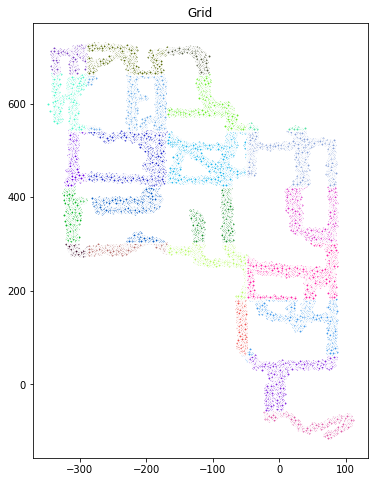

In [7]:
r = lambda: np.random.randint(0,255)
colors = ['#%02X%02X%02X' % (r(),r(),r()) for _ in range(grid.num_grid)]
fig = plt.figure(figsize=(6, 8))
ax = fig.add_subplot(1, 1, 1)
for k, col in zip(range(grid.num_grid), colors):
    my_members = np.sum(label_mask == k,axis=1) >= 1
    ax.plot(X[my_members, 0], X[my_members, 1], 'w',
            markerfacecolor=col, marker='.')
ax.set_title('Grid')
plt.show()

In [8]:
dis = []
for i in range(grid.num_grid):
    dis += [np.sum(np.sum(label_mask == i,axis=1)>=1)]

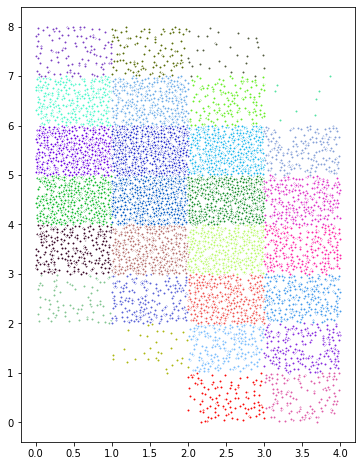

In [9]:
fig = plt.figure(figsize=(6, 8))
ax = fig.add_subplot(1, 1, 1)
for i,dense in enumerate(dis):
    row,line = divmod(i,grid.num_grid_x)
    x = np.random.rand(dense//50) + line
    y = np.random.rand(dense//50) + row
    ax.plot(x, y, 'w',markerfacecolor=colors[i], marker='.')
plt.show()


# Define Model

In [10]:
class Backbone(nn.Module):
    def __init__(self):
        super().__init__()
        self.resnet = resnet.resnet50(pretrained=True)
    def forward(self,input_data):
        dense_feat = self.resnet(input_data)
        return dense_feat
    
class NN(nn.Module):
    def __init__(self):
        super().__init__()
        self.global_context = vggnet.vggnet(input_channel=2048,opt="context")
        self.global_regressor = vggnet.vggnet(opt="regressor")
        
    def forward(self,input_data):
        context_feat = self.global_context(input_data)
        output,feature_t, feature_r = self.global_regressor(context_feat)
        return output, feature_t, feature_r

class GP(gpytorch.models.ApproximateGP):
    def __init__(self, inducing_points, output_dim=3):
        variational_distribution = gpytorch.variational.CholeskyVariationalDistribution(
            inducing_points.size(-2), batch_shape=torch.Size([output_dim])
        )
        variational_strategy = gpytorch.variational.MultitaskVariationalStrategy(
            gpytorch.variational.VariationalStrategy(
                self, inducing_points, variational_distribution, learn_inducing_locations=True
            ), num_tasks=output_dim
        )
        super().__init__(variational_strategy)
        self.mean_module = gpytorch.means.ConstantMean(batch_shape=torch.Size([output_dim]))
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RBFKernel(batch_shape=torch.Size([output_dim])),
            batch_shape=torch.Size([output_dim]))

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

class GPNode(nn.Module):
    def __init__(self,inducing_points):
        super().__init__()
        output_dim = inducing_points.shape[0]
        feat_dim = inducing_points.shape[-1]
        assert output_dim == args.output_dim
        assert feat_dim == args.feat_dim
        
        self.gp = GP(inducing_points)
        self.likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=output_dim) 
        
    def forward(self,input_data):
        output = self.gp(input_data)
        return output
    
class Model(nn.Module):
    def __init__(self,num_grid):
        super().__init__()
        self.backbone = Backbone()
        self.nn = NN()
        self.gps = nn.ModuleList()
        
        self.num_gp = num_grid
        
        for i in range(self.num_gp):
            inducing_points = torch.zeros(args.output_dim, args.batch_size, args.feat_dim)
            gp = GPNode(inducing_points)
            self.gps.append(gp)
        
    def forward_nn(self, input_data):
        dense_feat = self.backbone(input_data)
        output, feature_t, feature_r = self.nn(dense_feat)
        rot_pred = torch.split(output, [3, 4], dim=1)[1] # 4-dimention            
        return feature_t, rot_pred
    
    def forward_gp(self,gp,trans_feat):
        trans_pred = gp(trans_feat)
        return trans_pred

In [24]:
class Trainer:
    def __init__(self,grid,is_training=True,regressor_context_rate = [0.0,0.0]):
        self.model = Model(grid.num_grid).cuda()
        self.norm_mean = args.norm_mean.cuda()
        self.norm_std = args.norm_std.cuda()
        
        # disable learning backbone
        for param in self.model.backbone.parameters():
            param.requires_grad = False
        
        if is_training:
            # training tool
            self.optimizer = optim.Adam(self._optimize(regressor_context_rate))
            self.scheduler = optim.lr_scheduler.LambdaLR(optimizer=self.optimizer,
                                                             lr_lambda=lambda epoch: args.decay_rate**epoch)
        else:
            # disable all learning
            for param in self.model.parameters():
                param.requires_grad = False
        
    def load_model(self, file_name = 'pretrained.pth'):
        # load file info
        state_dict = torch.load(os.path.join(args.model_dir, file_name))
        if 'net.resnet.conv1.weight' in state_dict:
            print('Transform from old model.')
            # Part 1: backbone
            backbone_state_dict = self._from_old_model(state_dict,'backbone')
            print('Backbone parameters layer:',len(backbone_state_dict.keys()))
            self.model.backbone.load_state_dict(backbone_state_dict,strict = True)
            # Part 2: nn
            nn_state_dict = self._from_old_model(torch.load(os.path.join(args.model_dir, file_name)),'nn')
            print('NN parameters layer:',len(nn_state_dict.keys()))
            self.model.nn.load_state_dict(nn_state_dict,strict = True)
        else:
            print('Parameters layer:',len(state_dict.keys()))
            # load file to model
            self.model.load_state_dict(state_dict,strict = True)
        print('Model Structure:')
        # Display model structure
        for name, param in self.model.named_parameters():
            print(name, param.shape)
        print('Parameters layer:',len(self.model.state_dict().keys()))
    
    def _from_old_model(self, state_dict, select = 'backbone'):
        if select == 'backbone':
            for key in list(state_dict):
                if 'net.resnet.' in key:
                    state_dict[key.replace('net.resnet.','resnet.')] = state_dict.pop(key)
                else:
                    state_dict.pop(key)
        elif select == 'nn':
            for key in list(state_dict):
                if 'net.global_regressor.' in key:
                    state_dict[key.replace('net.global_regressor.','global_regressor.')] = state_dict.pop(key)
                elif 'net.global_context.' in key:
                    state_dict[key.replace('net.global_context.','global_context.')] = state_dict.pop(key)
                else:
                    state_dict.pop(key)
        return state_dict
    
    def save_model(self, file_name = 'model-{}-{}.pth'):
        checkpoint_path = os.path.join(args.model_dir, file_name)
        torch.save(self.model.state_dict(),checkpoint_path)
        print('Saving model to ' +  file_name)
        
    def _optimize(self,regressor_context_rate = [0.0,0.0]):
        optimizer = [
                {'params': self.model.gps.parameters(), \
                 'lr': args.learning_rate,'weight_decay':args.weight_decay}]
            
        if regressor_context_rate[0]!=0:
            optimizer += [{'params': self.model.nn.global_regressor.parameters(), \
                 'lr': args.learning_rate * regressor_context_rate[0],'weight_decay':args.weight_decay}]
            print('Regressor learn rate:',regressor_context_rate[0])
        else:
            for param in self.model.nn.global_regressor.parameters():
                param.requires_grad = False
                
        if regressor_context_rate[1]!=0:
            optimizer += [{'params': self.model.nn.global_context.parameters(), \
                 'lr': args.learning_rate * regressor_context_rate[1],'weight_decay':args.weight_decay}]
            print('Context learn rate:',regressor_context_rate[1])
        else:
            for param in self.model.nn.global_context.parameters():
                param.requires_grad = False
                
        return optimizer
            
    def train(self,x,y):
        # Step 0: zero grad
        self.optimizer.zero_grad()
        
        start = time.time()
        # Step 1: get data
        #labels = torch.from_numpy(pairwise_distances_argmin(y[:,:2].numpy(), mbk_means_cluster_centers)).cuda()
        label = np.zeros([y.shape[0],4])
        for i in range(y.shape[0]):
            label[i] = np.array(grid.in_grids(*y[i,:2]))
        
        x,y = x.cuda(),y.cuda()
        
        if args.is_normalization:
            y = normalize(y,self.norm_mean, self.norm_std) # input should be 7 dim       
            
        # Step 2: training
        assert self.model.training == True
        
        trans_loss = torch.tensor(0.).cuda()
        
        trans_target, rot_target = torch.split(y, [3, 4], dim=1)
        
        trans_feat, rot_pred = self.model.forward_nn(x)
        rot_loss = self._nn_loss(rot_pred,rot_target)
        
        gps_loss = np.zeros(self.model.num_gp)
        for i,gp in enumerate(self.model.gps):
            num_data = dis[i]
            if num_data > 0:
                label_mask = np.sum(label == i,axis=1) >= 1
                sub_x = trans_feat[label_mask]
                sub_y = trans_target[label_mask] # unnormalized data 
                if sub_y.shape[0]>0:
                    gp_loss = self._gp_loss(gp,num_data,sub_x,sub_y)
                    gps_loss[i] = float(gp_loss)
                    trans_loss += gp_loss #* int(sub_y.shape[0])/args.batch_size
        trans_loss = trans_loss/self.model.num_gp
        total_loss = trans_loss + args.lamda_weights * rot_loss
        
        #Step 3: update
        total_loss.backward()
        self.optimizer.step()
        
        batch_time = time.time() - start
        return float(total_loss), batch_time, gps_loss
    
    def _nn_loss(self,rot_pred,rot_target):
        rot_loss = 1. - torch.mean(torch.square(torch.sum(torch.mul(rot_pred,rot_target),dim=1)))
        return rot_loss
        
    def _gp_loss(self,gp,num_data,trans_feat,trans_target):
        # predict
        trans_pred = self.model.forward_gp(gp,trans_feat)
        mll = gpytorch.mlls.PredictiveLogLikelihood(gp.likelihood, gp.gp, num_data = num_data)
        
        # trans loss
        trans_loss = -1.*mll(trans_pred, trans_target)
        
        return trans_loss
    
    def _eval_gp(self, gp, trans_pred):
        c_mean, c_var = trans_pred.mean, trans_pred.variance
        y_mean, y_var = gp.likelihood(trans_pred).mean, gp.likelihood(trans_pred).variance
        
        return y_mean, c_mean, c_var
    
    def _sample(self, mean, var, num_sample = 100):
        dist = Normal(mean, var)
        samples = dist.sample([num_sample])
        return samples

    def eval_forward(self,x,y,num_sample = 100,output_denormalize = True,label_from_gp = True):
        # Step 1: get data
        x,y = x.cuda(),y.cuda()
        
        if not label_from_gp:
            #labels = pairwise_distances_argmin(y[:,:2].cpu().numpy(), mbk_means_cluster_centers)
            
            labels = np.zeros([y.shape[0],4])
            for i in range(y.shape[0]):
                labels[i] = np.array(grid.in_grids(*y[i,:2].cpu().numpy()))
            
        else:
            global_trans_pred,_ = global_trainer.model(x)
            global_trans_pred, _, _ = global_trainer._eval_gp(global_trans_pred)
            global_trans_pred = denormalize_navie(global_trans_pred, global_trainer.norm_mean, global_trainer.norm_std)
            
            #labels = pairwise_distances_argmin(global_trans_pred[:,:2].cpu().numpy(), mbk_means_cluster_centers)
            labels = np.zeros([y.shape[0],4])
            for i in range(y.shape[0]):
                labels[i] = np.array(grid.in_grids(*global_trans_pred[i,:2].cpu().numpy()))
            
        if args.is_normalization:
            y = normalize(y,self.norm_mean, self.norm_std)
        
        # Step 2: forward
        assert self.model.training == False
        trans_feat, rot_pred = self.model.forward_nn(x)
        
        trans_pred = torch.zeros(y.shape[0],args.output_dim).cuda()
        trans_mean = torch.zeros(y.shape[0],args.output_dim).cuda()
        trans_var = torch.zeros(y.shape[0],args.output_dim).cuda()

        for i,gp in enumerate(trainer.model.gps):
            #label_mask = labels == i
            label_mask = np.sum(labels == i,axis=1) >= 1
            sub_x = trans_feat[label_mask]
            if sub_x.shape[0]>0:
                sub_trans_pred = self.model.forward_gp(gp,sub_x)
                sub_trans_pred, sub_trans_mean, sub_trans_var = self._eval_gp(gp, sub_trans_pred)
                if args.is_normalization and output_denormalize:
                    trans_pred[label_mask] += denormalize_navie(sub_trans_pred,self.norm_mean,self.norm_std)/4
                    trans_mean[label_mask] += denormalize_navie(sub_trans_mean,self.norm_mean,self.norm_std)/4
                    trans_var[label_mask] += sub_trans_var.mul(self.norm_std)/4
                else:
                    trans_pred[label_mask] += sub_trans_pred/4
                    trans_mean[label_mask] += sub_trans_mean/4
                    trans_var[label_mask] += sub_trans_var/4
        
        if args.is_normalization and output_denormalize:
            y = denormalize(y, self.norm_mean, self.norm_std)
        
        samples = self._sample(trans_mean, trans_var, num_sample)
        
        # Step 3: split output
        trans_target, rot_target = torch.split(y, [3, 4], dim=1)
        
        return trans_pred, rot_pred, trans_target, rot_target, samples

trainer = Trainer(grid)
#trainer = Trainer(grid,regressor_context_rate = [0.1,0.])

trainer.load_model('pretrained.pth')
#trainer.load_model('model-3-1500.pth')
#trainer.load_model('model-2-1000.pth')

Parameters layer: 666
Model Structure:
backbone.resnet.conv1.weight torch.Size([64, 1, 7, 7])
backbone.resnet.bn1.weight torch.Size([64])
backbone.resnet.bn1.bias torch.Size([64])
backbone.resnet.layer1.0.conv1.weight torch.Size([64, 64, 1, 1])
backbone.resnet.layer1.0.bn1.weight torch.Size([64])
backbone.resnet.layer1.0.bn1.bias torch.Size([64])
backbone.resnet.layer1.0.conv2.weight torch.Size([64, 64, 3, 3])
backbone.resnet.layer1.0.bn2.weight torch.Size([64])
backbone.resnet.layer1.0.bn2.bias torch.Size([64])
backbone.resnet.layer1.0.conv3.weight torch.Size([256, 64, 1, 1])
backbone.resnet.layer1.0.bn3.weight torch.Size([256])
backbone.resnet.layer1.0.bn3.bias torch.Size([256])
backbone.resnet.layer1.0.downsample.0.weight torch.Size([256, 64, 1, 1])
backbone.resnet.layer1.0.downsample.1.weight torch.Size([256])
backbone.resnet.layer1.0.downsample.1.bias torch.Size([256])
backbone.resnet.layer1.1.conv1.weight torch.Size([64, 256, 1, 1])
backbone.resnet.layer1.1.bn1.weight torch.Size(

In [18]:
for param in trainer.model.nn.global_regressor.regressor.fc1_rot.parameters():
    param.requires_grad = False
for param in trainer.model.nn.global_regressor.regressor.fc2_rot.parameters():
    param.requires_grad = False
for param in trainer.model.nn.global_regressor.regressor.fc3_rot.parameters():
    param.requires_grad = False
for param in trainer.model.nn.global_regressor.regressor.logits_r.parameters():
    param.requires_grad = False

for name, param in trainer.model.named_parameters():
    if param.requires_grad:
        print (name, param.shape)

gps.0.gp.variational_strategy.base_variational_strategy.inducing_points torch.Size([3, 300, 128])
gps.0.gp.variational_strategy.base_variational_strategy._variational_distribution.variational_mean torch.Size([3, 300])
gps.0.gp.variational_strategy.base_variational_strategy._variational_distribution.chol_variational_covar torch.Size([3, 300, 300])
gps.0.gp.mean_module.constant torch.Size([3, 1])
gps.0.gp.covar_module.raw_outputscale torch.Size([3])
gps.0.gp.covar_module.base_kernel.raw_lengthscale torch.Size([3, 1, 1])
gps.0.likelihood.raw_noise torch.Size([1])
gps.0.likelihood.noise_covar.raw_noise torch.Size([3])
gps.1.gp.variational_strategy.base_variational_strategy.inducing_points torch.Size([3, 300, 128])
gps.1.gp.variational_strategy.base_variational_strategy._variational_distribution.variational_mean torch.Size([3, 300])
gps.1.gp.variational_strategy.base_variational_strategy._variational_distribution.chol_variational_covar torch.Size([3, 300, 300])
gps.1.gp.mean_module.constant

# Training

## Training Epoch

In [20]:
trainer.model.train()
for e in range(args.num_epochs):
#for e in range(1):
    train_loss = 0.
    for b, data in enumerate(dataloader, 0):
        x,y = data.values()
        
        single_loss, batch_time, gps_loss = trainer.train(x,y)
        
        with torch.no_grad():
            train_loss += single_loss
            if args.tensorboard:
                data2tensorboard(writer,single_loss,train_loss/(b+1),e*len(dataloader)+(b+1))
                writer.add_scalars('gps_loss',
                   {'gp'+str(i):gps_loss[i] for i in range(trainer.model.num_gp) if gps_loss[i] != 0},
                   e*len(dataloader)+(b+1))
            if ((b+1)%args.display == 0):
                display_loss(e*len(dataloader)+(b+1),args.num_epochs*len(dataloader),e,
                              train_loss/(b+1),batch_time,trainer.scheduler.get_last_lr()[0])          
            if (e * len(dataloader) + (b+1)) % args.save_every == 0:
                trainer.save_model('model-{}-{}.pth'.format(e, e * len(dataloader) + (b+1)))
            if trainer.scheduler.get_last_lr()[0] > args.learning_rate_clip and (e * len(dataloader) + (b+1)) % 180 == 0:
                trainer.scheduler.step()

10/85400 (epoch 0), train_loss = 3.21457734, time/batch = 1.490, learning rate = 0.05000000
20/85400 (epoch 0), train_loss = 2.74344957, time/batch = 1.475, learning rate = 0.05000000
30/85400 (epoch 0), train_loss = 2.41233669, time/batch = 1.495, learning rate = 0.05000000
40/85400 (epoch 0), train_loss = 2.07326678, time/batch = 1.495, learning rate = 0.05000000
50/85400 (epoch 0), train_loss = 1.72591091, time/batch = 1.493, learning rate = 0.05000000
60/85400 (epoch 0), train_loss = 1.40719763, time/batch = 1.495, learning rate = 0.05000000
70/85400 (epoch 0), train_loss = 1.10584007, time/batch = 1.483, learning rate = 0.05000000
80/85400 (epoch 0), train_loss = 0.81598543, time/batch = 1.462, learning rate = 0.05000000
90/85400 (epoch 0), train_loss = 0.54786285, time/batch = 1.516, learning rate = 0.05000000
100/85400 (epoch 0), train_loss = 0.31062149, time/batch = 1.510, learning rate = 0.05000000
110/85400 (epoch 0), train_loss = 0.09211406, time/batch = 1.508, learning rate

904/85400 (epoch 2), train_loss = -6.62307473, time/batch = 1.509, learning rate = 0.00840350
914/85400 (epoch 2), train_loss = -6.64184614, time/batch = 1.491, learning rate = 0.00840350
924/85400 (epoch 2), train_loss = -6.66313698, time/batch = 1.521, learning rate = 0.00840350
934/85400 (epoch 2), train_loss = -6.67543423, time/batch = 1.512, learning rate = 0.00840350
944/85400 (epoch 2), train_loss = -6.68711781, time/batch = 1.492, learning rate = 0.00840350
954/85400 (epoch 2), train_loss = -6.70330667, time/batch = 1.495, learning rate = 0.00840350
964/85400 (epoch 2), train_loss = -6.70603565, time/batch = 1.510, learning rate = 0.00840350
974/85400 (epoch 2), train_loss = -6.71182787, time/batch = 1.517, learning rate = 0.00840350
984/85400 (epoch 2), train_loss = -6.71883713, time/batch = 1.510, learning rate = 0.00840350
994/85400 (epoch 2), train_loss = -6.72040131, time/batch = 1.513, learning rate = 0.00840350
Saving model to model-2-1000.pth
1004/85400 (epoch 2), train

1778/85400 (epoch 4), train_loss = -7.11813084, time/batch = 1.492, learning rate = 0.00201768
1788/85400 (epoch 4), train_loss = -7.11992258, time/batch = 1.521, learning rate = 0.00201768
1798/85400 (epoch 4), train_loss = -7.11850395, time/batch = 1.508, learning rate = 0.00201768
1808/85400 (epoch 4), train_loss = -7.12482234, time/batch = 1.522, learning rate = 0.00141238
1818/85400 (epoch 4), train_loss = -7.12294541, time/batch = 1.531, learning rate = 0.00141238
1828/85400 (epoch 4), train_loss = -7.12599576, time/batch = 1.512, learning rate = 0.00141238
1838/85400 (epoch 4), train_loss = -7.13011302, time/batch = 1.505, learning rate = 0.00141238
1848/85400 (epoch 4), train_loss = -7.13078151, time/batch = 1.492, learning rate = 0.00141238
1858/85400 (epoch 4), train_loss = -7.13355397, time/batch = 1.511, learning rate = 0.00141238
1868/85400 (epoch 4), train_loss = -7.13464385, time/batch = 1.508, learning rate = 0.00141238
1878/85400 (epoch 4), train_loss = -7.13323828, ti

2652/85400 (epoch 6), train_loss = -7.17818922, time/batch = 1.491, learning rate = 0.00033911
2662/85400 (epoch 6), train_loss = -7.17667168, time/batch = 1.464, learning rate = 0.00033911
2672/85400 (epoch 6), train_loss = -7.18086594, time/batch = 1.516, learning rate = 0.00033911
2682/85400 (epoch 6), train_loss = -7.18369702, time/batch = 1.491, learning rate = 0.00033911
2692/85400 (epoch 6), train_loss = -7.18461404, time/batch = 1.504, learning rate = 0.00033911
2702/85400 (epoch 6), train_loss = -7.18552863, time/batch = 1.502, learning rate = 0.00023738
2712/85400 (epoch 6), train_loss = -7.18852469, time/batch = 1.531, learning rate = 0.00023738
2722/85400 (epoch 6), train_loss = -7.19115913, time/batch = 1.506, learning rate = 0.00023738
2732/85400 (epoch 6), train_loss = -7.19247031, time/batch = 1.489, learning rate = 0.00023738
2742/85400 (epoch 6), train_loss = -7.19591172, time/batch = 1.505, learning rate = 0.00023738
2752/85400 (epoch 6), train_loss = -7.19457216, ti

3526/85400 (epoch 8), train_loss = -7.19940444, time/batch = 1.502, learning rate = 0.00005699
3536/85400 (epoch 8), train_loss = -7.19890518, time/batch = 1.512, learning rate = 0.00005699
3546/85400 (epoch 8), train_loss = -7.20198582, time/batch = 1.484, learning rate = 0.00005699
3556/85400 (epoch 8), train_loss = -7.20254087, time/batch = 1.490, learning rate = 0.00005699
3566/85400 (epoch 8), train_loss = -7.20450766, time/batch = 1.511, learning rate = 0.00005699
3576/85400 (epoch 8), train_loss = -7.20282716, time/batch = 1.502, learning rate = 0.00005699
3586/85400 (epoch 8), train_loss = -7.20232019, time/batch = 1.504, learning rate = 0.00005699
3596/85400 (epoch 8), train_loss = -7.19989665, time/batch = 1.489, learning rate = 0.00005699
3606/85400 (epoch 8), train_loss = -7.19856476, time/batch = 1.561, learning rate = 0.00003990
3616/85400 (epoch 8), train_loss = -7.19796466, time/batch = 1.483, learning rate = 0.00003990
3626/85400 (epoch 8), train_loss = -7.20147017, ti

KeyboardInterrupt: 

In [26]:
from torch.distributions import Normal

In [27]:
trainer.model.eval()
train_loss = 0.
for b, data in enumerate(dataloader, 0):
    x,y = data.values()
    trans_pred, rot_pred, trans_target, rot_target, samples = trainer.eval_forward(x,y,label_from_gp=False)
    break


In [28]:
trans_pred

tensor([[  -251.6090,    395.0049,    -14.1716],
        [  -199.9205,    404.0054,    -13.9346],
        [    53.1140,    303.3723,     -1.4355],
        [  -118.7063,    650.6263,    -12.2756],
        [  -153.3797,    582.7374,    -11.9117],
        [  -170.5940,    708.7433,    -12.4246],
        [    24.8409,    411.9714,     -1.9690],
        [    14.1976,    513.0334,     -1.5857],
        [  -180.8436,    615.9232,    -12.9609],
        [   -77.9026,    310.8523,     -8.5654],
        [   -28.0241,    166.6618,     -3.4958],
        [  -159.1334,    513.7544,    -12.0002],
        [   -68.8912,    257.1877,     -7.0583],
        [  -168.0529,    286.7792,    -10.7806],
        [  -180.4227,    573.1487,    -12.5360],
        [  -182.1089,    629.1108,    -13.0113],
        [   -44.8192,    255.0040,     -6.5502],
        [    26.2846,    413.7262,     -1.9128],
        [   -83.6464,    486.4515,    -10.8920],
        [    42.6730,     40.7272,     -2.5604],
        [  -178.7260

In [29]:
trans_target

tensor([[  -251.7390,    395.2637,    -14.1743],
        [  -198.6936,    402.9061,    -13.9148],
        [    52.0521,    303.7904,     -1.3849],
        [  -118.5981,    651.3653,    -12.1921],
        [  -153.8077,    582.9624,    -11.9035],
        [  -167.9841,    709.2805,    -12.4493],
        [    24.5945,    411.4151,     -1.9553],
        [    12.7877,    513.0983,     -1.6329],
        [  -180.8261,    615.5155,    -12.9651],
        [   -77.8448,    310.6495,     -8.5787],
        [   -26.4332,    165.5682,     -3.4756],
        [  -159.8635,    513.9821,    -12.0035],
        [   -68.3788,    257.1815,     -7.0541],
        [  -168.2656,    287.9940,    -10.7841],
        [  -180.6883,    573.8165,    -12.5731],
        [  -183.3477,    630.2010,    -12.9946],
        [   -45.2777,    255.4531,     -6.6207],
        [    28.8287,    413.8036,     -1.9079],
        [   -83.5086,    486.7444,    -10.8882],
        [    42.2668,     41.0190,     -2.5735],
        [  -179.0882